# Utils

## data_definitions.py

In [1]:
import collections
import math

#from genetic.utils import pairwise_circle, _normal, _eq_line, _eq_intersection_point

# CartesianPoint = collections.namedtuple('CartesianPoint', 'x y')
GeoPoint = collections.namedtuple("GeoPoint", "latitude, longitude, altitude")
Version = collections.namedtuple("Version", "major, minor")


class CartesianPoint:
    def __init__(self, x, y, z=0):
        self.x = x
        self.y = y
        self.z = z

    def __repr__(self):
        return f"[{self.x}, {self.y}, {self.z}]"


class Mapa:
    def __init__(self, origin, destination, areas_n=None, areas_b=None, inflation_rate=0.1):
        self.origin = origin  # CartesianPoint : Define o ponto de partida da rota
        self.destination = destination  # CartesianPoint : Define o ponto de destino da rota
        self.areas_n = areas_n  # [area, ...] : Areas nao-navegaveis
        #                       # area = [CartesianPoint(),...]
        self.areas_n_inf = [self._inflate_area(area, inflation_rate=inflation_rate) for area in areas_n]

        self.areas_b = areas_b  # [area, ...] : Areas bonificadoras

    def _inflate_area(self, area, inflation_rate):

        lines = []

        for V1, V2 in pairwise_circle(area):
            N = _normal(V1, V2)

            NV1 = CartesianPoint(
                V1.x + N.x * inflation_rate, V1.y + N.y * inflation_rate
            )
            NV2 = CartesianPoint(
                V2.x + N.x * inflation_rate, V2.y + N.y * inflation_rate
            )

            a, b, c = _eq_line(NV1, NV2)
            lines.append((a, b, c))

            # if verbose:
            #     print(f"V1:{NV1} V2:{NV2}  ->  L:({a}x + {b}y + {c} = 0)")

        new_area = []

        for L1, L2 in pairwise_circle(lines):
            x, y = _eq_intersection_point(L1[0], L1[1], L1[2], L2[0], L2[1], L2[2])
            new_area.append(CartesianPoint(x, y))

            # if verbose:
            #     print(
            #         f"L1:({L1[0]}x + {L1[1]}y + {L1[2]} = 0) L2:({L2[0]}x + {L2[1]}y + {L2[2]} = 0)  ->  V=({x},{y})"
            #     )

        return new_area


class Conversor:
    def list_geo_to_cart(l, geo_home):
        for i in l:
            yield Conversor.geo_to_cart(i, geo_home)

    def list_cart_to_geo(l, geo_home):
        for i in l:
            yield Conversor.cart_to_geo(i, geo_home)

    def geo_to_cart(geo_point, geo_home):
        def calc_y(lat, lat_):
            return (lat - lat_) * (10000000.0 / 90)

        def calc_x(longi, longi_, lat_):
            return (longi - longi_) * (
                6400000.0 * (math.cos(lat_ * math.pi / 180) * 2 * math.pi / 360)
            )

        x = calc_x(geo_point.longitude, geo_home.longitude, geo_home.latitude)
        y = calc_y(geo_point.latitude, geo_home.latitude)

        # return CartesianPoint(x, y, geo_point.altitude)
        return CartesianPoint(x, y)

    def cart_to_geo(cartesian_point, geo_home):
        def calc_latitude_y(lat_, y):
            return ((y * 90) / 10000000.0) + lat_

        def calc_longitude_x(lat_, longi_, x):
            return ((x * 90) / (10008000 * math.cos(lat_ * math.pi / 180))) + longi_

        longitude_x = calc_longitude_x(
            geo_home.latitude, geo_home.longitude, cartesian_point.x
        )
        latitude_y = calc_latitude_y(geo_home.latitude, cartesian_point.y)

        # return GeoPoint(longitude_x, latitude_y, cartesian_point.z)
        return GeoPoint(longitude_x, latitude_y, 10)


## utils.py

In [2]:
import itertools
import collections
from scipy.stats import norm

import math


Vector = collections.namedtuple("Vector", "x y")


# Support Functions
# _________________________________________________________________________________________________
def pairwise_circle(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ... (s<last>,s0)"
    a, b = itertools.tee(iterable)
    first_value = next(b, None)
    return itertools.zip_longest(a, b, fillvalue=first_value)


def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = itertools.tee(iterable)
    next(b, None)
    return zip(a, b)


def boundary(val, val_min, val_max):
    if val < val_min:
        return val_min
    if val > val_max:
        return val_max
    return val


# Ray Casting Algorithm
# _________________________________________________________________________________________________
epsilon = 0.00001  # Used on the Ray Casting Algorithm


def point_in_polygon(point, polygon):
    # Using ray_casting algorithm
    # https://rosettacode.org/wiki/Ray-casting_algorithm

    count = 0

    for vertex1, vertex2 in pairwise_circle(polygon):

        if vertex1.y < vertex2.y:
            A = vertex1
            B = vertex2
        else:
            A = vertex2
            B = vertex1

        if ray_intersects_segment(point, A, B):
            count += 1

    if count % 2 == 0:  # Odd
        return False
    else:
        return True  # Inside the polygon


def ray_intersects_segment(P, A, B):
    # P : the point from which the ray starts
    # A : the end-point of the segment with the smallest y coordinate
    #     (A must be "below" B)
    # B : the end-point of the segment with the greatest y coordinate
    #     (B must be "above" A)

    # To avoid the "ray on vertex" problem, the point is moved upward of a small quantity epsilon.
    # if P.y == A.y or P.y == B.y:
    P.y += epsilon

    # Point higher or lower than polygon
    if P.y < A.y or P.y > B.y:
        return False

    # Point to the right of the polygon
    elif P.x >= max(A.x, B.x):
        return False

    else:

        if P.x < min(A.x, B.x):
            return True

        else:

            if A.x != B.x:
                m_red = (B.y - A.y) / (B.x - A.x)
            else:
                m_red = 99999999  # Infinite

            if A.x != P.x:
                m_blue = (P.y - A.y) / (P.x - A.x)
            else:
                m_blue = 99999999  # Infinite

            if m_blue >= m_red:
                return True
            else:
                return False


# Segment Intersection
# _________________________________________________________________________________________________
def segment_in_polygon(wp1, wp2, polygon):
    # count = 0
    # print('Segment: {}-{}'.format(wp1,wp2))

    for vertex1, vertex2 in pairwise_circle(polygon):
        A = vertex1
        B = vertex2

        if segment_intersects_segment(wp1, wp2, A, B):
            return True
    return False


def segment_intersects_segment(p1, q1, p2, q2):
    # Returns true if line segment 'p1q1' and 'p2q2' intersect.
    # Based on the algorithm from https://www.geeksforgeeks.org/check-if-two-given-line-segments-intersect/

    # Two segments (p1,q1) and (p2,q2) intersect if and only if one of the following two conditions is verified:
    #
    # 1. General Case:
    # – (p1, q1, p2) and (p1, q1, q2) have different orientations and
    # – (p2, q2, p1) and (p2, q2, q1) have different orientations.
    #
    # 2. Special Case
    # – (p1, q1, p2), (p1, q1, q2), (p2, q2, p1), and (p2, q2, q1) are all collinear and
    # – the x-projections of (p1, q1) and (p2, q2) intersect
    # – the y-projections of (p1, q1) and (p2, q2) intersect

    # Find the four orientations needed for general and
    # special cases
    o1 = orientation(p1, q1, p2)
    o2 = orientation(p1, q1, q2)
    o3 = orientation(p2, q2, p1)
    # print(p2, q2, p1, o3)
    o4 = orientation(p2, q2, q1)
    # print(o1,o2,o3,o4)

    # 1. General case
    if o1 != o2 and o3 != o4:
        return True

    # 2. Special Cases
    # p1, q1 and p2 are colinear and p2 lies on segment p1q1
    if o1 == 0 and on_segment(p1, p2, q1):
        return True

    # p1, q1 and q2 are colinear and q2 lies on segment p1q1
    if o2 == 0 and on_segment(p1, q2, q1):
        return True

    # p2, q2 and p1 are colinear and p1 lies on segment p2q2
    if o3 == 0 and on_segment(p2, p1, q2):
        return True

    # p2, q2 and q1 are colinear and q1 lies on segment p2q2
    if o4 == 0 and on_segment(p2, q1, q2):
        return True

    # Doesn't fall in any of the above cases
    return False


def on_segment(p, q, r):
    # Given three colinear points p, q, r, the function checks if
    # point q lies on line segment 'pr'
    if (
        q.x <= max(p.x, r.x)
        and q.x >= min(p.x, r.x)
        and q.y <= max(p.y, r.y)
        and q.y >= min(p.y, r.y)
    ):
        return True
    else:
        return False


def orientation(p, q, r):
    # To find orientation of ordered triplet (p, q, r).
    # The function returns following values
    # 0 --> p, q and r are colinear
    # 1 --> Clockwise
    # 2 --> Counterclockwise

    # See https://www.geeksforgeeks.org/orientation-3-ordered-points/
    # for details of below formula.

    val = (q.y - p.y) * (r.x - q.x) - ((q.x - p.x) * (r.y - q.y))
    # print('\n---\ndebug')
    # print((q.y - p.y), (r.x - q.x), (q.x - p.x), (r.y - q.y))
    # print(val)
    if val == 0:
        return 0  # colinear

    return 1 if val > 0 else 2  # clock or counterclock wise


# Chance Constraint
# _________________________________________________________________________________________________
def _distance_wp_area(wp, area):
    # Calculates the distance between one point P and an area area
    max_distance = -math.inf

    for A, B in pairwise_circle(area):
        distance = _distance_wp_line(wp, A, B)
        max_distance = max(max_distance, distance)

    return max_distance


def _normal(A, B):
    # Director vector
    D = Vector((A.x - B.x), (A.y - B.y))

    # Normalized normal vector of line AB
    aux = (math.sqrt(D.y ** 2 + D.x ** 2)) + 1 * 10 ** (-8)
    N = Vector((D.y) / aux, (-D.x) / aux)

    return N


def _distance_wp_line(P, A, B):
    # Calculates the distance between the point P and the line that crosses A and B

    #     # Director vector
    #     D = Vector((A.x-B.x),(A.y-B.y))

    #     # Normal vector of line AB
    #     # N = Vector(-D.y, D.x)

    #     # Normalized normal vector of line AB
    #     aux = (math.sqrt(D.y**2+D.x**2))+1*10**(-8)
    #     N = Vector( (D.y)/aux, (-D.x)/aux )
    N = _normal(A, B)

    b = N.x * A.x + N.y * A.y

    dist = P.x * N.x + P.y * N.y - b

    # if debug:
    #   print(A, B, P, dist)

    return dist


def d_distance_wp_line(P, A, B):
    # Calculates the distance between the point P and the line that crosses A and B

    # Director vector
    D = Vector((A.x - B.x), (A.y - B.y))

    # Normal vector of line AB
    # N = Vector(-D.y, D.x)

    # Normalized normal vector of line AB
    aux = (math.sqrt(D.y ** 2 + D.x ** 2)) + 1 * 10 ** (-8)
    N = Vector((D.y) / aux, (-D.x) / aux)

    b = N.x * A.x + N.y * A.y

    dist = P.x * N.x + P.y * N.y - b

    # if debug:
    #   print(A, B, P, dist)

    return dist, N


def _prob_collision(distance, uncertainty):
    # Survival function (also defined as 1 - cdf, but sf is sometimes more accurate).
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html

    # mi    : média         : location
    # sigma : desvio padrão : scale

    return norm.sf(distance, loc=0, scale=uncertainty)


# Area Inflation
# _________________________________________________________________________________________________

# using general equation of line
def _eq_line(P, Q):
    # general equation of line that intersect two points P and Q
    # https://stackoverflow.com/questions/13242738/how-can-i-find-the-general-form-equation-of-a-line-from-two-points

    # Ax + By + C = 0

    A = P.y - Q.y
    B = Q.x - P.x
    C = (P.x * Q.y) - (Q.x * P.y)

    return A, B, C


def _eq_intersection_point(a, b, c, j, k, l):
    # find the intersection point of two lines, given their general equation arguments
    # https://stackoverflow.com/questions/13244666/how-can-i-find-the-intersection-of-two-lines-in-general-equation-form

    aux = b * j - a * k

    y = (a * l - c * j) / aux
    x = (c * k - b * l) / aux

    return x, y


def euclidean_distance(A, B):
    return math.sqrt((B.x - A.x) ** 2 + (B.y - A.y) ** 2)


## visualization.py

In [3]:
import pandas as pd
# import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.path import Path

#import plotly.graph_objects as go

from sklearn import preprocessing


cor_area_nn = "#25283d"  # Yankees Blue
cor_area_p = "#8f3985"  # Plum
cor_area_b = "#07beb8"  # Tiffany Blue
cor_waypoints = "#aa1155"  # Jazzberry Jam
cor_ori_dest = "#880044"  # Pink Raspberry


def new_shape(vert, color="navajowhite", lw=0.25):

    # print(vert)
    assert len(vert) >= 3, "At least 3 vertices to form a shape"

    vert.append(vert[0])

    vertices = []

    for vertex in vert:
        vertices.append((vertex.x, vertex.y))

    colors = {"n": cor_area_nn, "p": cor_area_p, "b": cor_area_b}

    color = colors[color] if color in colors else color

    codes = [Path.MOVETO]
    for _ in range(1, len(vertices) - 1):
        codes.append(Path.LINETO)
    codes.append(Path.CLOSEPOLY)

    path = Path(vertices, codes)

    patch = patches.PathPatch(path, facecolor=color, lw=lw, alpha=0.6)

    return patch


def plot_map(wp_style="-x", **kwargs):
    # Optional arguments:
    # areas, labels, origem, destino, waypoints, texts

    if "figsize" in kwargs:
        figsize = kwargs["figsize"]
    else:
        figsize = (8, 8)

    fig, ax = plt.subplots(figsize=figsize)

    # Plot areas
    if "areas" in kwargs and "labels" in kwargs:
        areas = kwargs["areas"]
        labels = kwargs["labels"]
        patches = [
            new_shape(vertice, color=label) for vertice, label in zip(areas, labels)
        ]
        for patch in patches:
            ax.add_patch(patch)

        if "texts" in kwargs:
            for text, area in zip(kwargs['texts'], areas):
                ax.annotate(text, (area[0].x, area[0].y))

    # Plot origin and destination
    if "origem" in kwargs and "destino" in kwargs:
        origem = kwargs["origem"]
        destino = kwargs["destino"]
        ax.plot([origem.x, destino.x], [origem.y, destino.y], "o", color=cor_ori_dest)

    # Plot a route with its waypoints
    if "waypoints" in kwargs:
        waypoints = kwargs["waypoints"]
        waypoints = list(map(list, zip(*waypoints)))
        ax.plot(
            waypoints[0], waypoints[1], wp_style, color=cor_waypoints, linewidth=2
        )  # marker='x', linestyle='solid'
        if "texts" in kwargs:
            for i, text in enumerate(kwargs["texts"]):
                ax.annotate(text, (waypoints[0][i], waypoints[1][i]))

    # Plot multiple routes with waypoints, along with name and specific colors
    if "multi_waypoints" in kwargs:
        for waypoints, label, color in zip(
            kwargs["multi_waypoints"], kwargs["names"], kwargs["colors"]
        ):
            waypoints = list(map(list, zip(*waypoints)))
            ax.plot(
                waypoints[0],
                waypoints[1],
                wp_style,
                color=color,
                linewidth=2,
                label=label,
            )  # marker='x', linestyle='solid'
            if "texts" in kwargs:
                for i, text in enumerate(kwargs["texts"]):
                    ax.annotate(text, (waypoints[0][i], waypoints[1][i]))

    if "stress" in kwargs:
        # Plot waypoints
        if "points" in kwargs:
            for wp, text in zip(kwargs["points"], kwargs["texts"]):
                if text == "T":
                    in_color = cor_area_b
                else:
                    in_color = cor_waypoints

                ax.plot(wp[0], wp[1], wp_style, color=in_color, linewidth=2)
                ax.annotate(text, (wp[0], wp[1]))

        # Plot segments
        if "segments" in kwargs and "texts" in kwargs:
            i = 0
            for segment, text in zip(kwargs["segments"], kwargs["texts"]):
                X = [segment[0].x, segment[1].x]
                Y = [segment[0].y, segment[1].y]

                if text == "T":
                    in_color = cor_area_b
                else:
                    in_color = cor_waypoints
                ax.plot(X, Y, wp_style, color=in_color, linewidth=2)

                ax.annotate(text + str(i), (X[0], Y[0]))
                i += 1

        # Plot chance constraints tests
        if "chance" in kwargs:

            base_das_normais = []

            for segment, normal, segment_text in zip(
                kwargs["segments"], kwargs["normals"], kwargs["segment_texts"]
            ):
                X = [segment[0].x, segment[1].x]
                Y = [segment[0].y, segment[1].y]
                ax.plot(X, Y, wp_style, color=cor_waypoints, linewidth=3)
                ax.annotate(segment_text[0], (X[0], Y[0]))
                ax.annotate(segment_text[1], (X[1], Y[1]))

                x = _graph_sub(segment[0].x, segment[1].x)
                y = _graph_sub(segment[0].y, segment[1].y)
                base_das_normais.append([x, y])
                ax.quiver(
                    x, y, normal.x, normal.y, angles="xy", scale_units="xy", scale=1
                )

            for P, point_text in zip(kwargs["pointes"], kwargs["point_texts"]):
                ax.plot(P.x, P.y, "o", color=cor_area_nn, linewidth=4)
                ax.annotate(point_text, (P.x, P.y * 1.05))

                for normal, dist in zip(base_das_normais, kwargs["distances"]):
                    X = [P.x, normal[0]]
                    Y = [P.y, normal[1]]
                    ax.plot(X, Y, "", color=cor_area_nn, linewidth=2)

                    x = _graph_sub(P.x, normal[0])
                    y = _graph_sub(P.y, normal[1])
                    ax.annotate(str(dist), (x, y * 1.05))

    # Set size
    if "margin" in kwargs:
        sl = kwargs["margin"]
    else:
        sl = 1

    automin, automax = ax.get_xlim()
    plt.xlim(automin - sl, automax + sl)
    automin, automax = ax.get_ylim()
    plt.ylim(automin - sl, automax + sl)
    plt.gca().set_aspect("equal", adjustable="box")

    if "title" in kwargs:
        plt.title(kwargs["title"])

    # plt.show()
    # plt.savefig('out.png')

    if "save" in kwargs:
        plt.savefig(kwargs["save"])

    if "show" in kwargs:
        plt.show()


def plot_stats(ag_trace, normalize=True):
    dft = pd.DataFrame.from_dict(ag_trace)

    if normalize:
        x = dft.values  # returns a numpy array
        min_max_scaler = preprocessing.MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(x)
        dft = pd.DataFrame(x_scaled, columns=dft.columns)

    fig = go.Figure()

    for column in dft.columns:
        fig.add_trace(go.Scatter(x=dft.index, y=dft[column], name=column))
    fig.show()


def _graph_sub(A, B):
    menor = min(A, B)
    maior = max(A, B)

    return menor + ((maior - menor) / 2)


def vis_mapa(mapa, route=None, **qwargs):
    areas = []
    tipos = []
    
    if mapa.areas_n:
        areas_n = [area for area in itertools.chain(mapa.areas_n, mapa.areas_n_inf)]
        tipos_n = ['n' for _ in range(len(areas_n))]
        areas.extend(areas_n)
        tipos.extend(tipos_n)
    
    if mapa.areas_b:
        areas_b = mapa.areas_b
        tipos_b = ['b' for _ in range(len(areas_b))]
        areas.extend(areas_b)
        tipos.extend(tipos_b)

    kwargs = {
        "areas": areas,
        "labels": tipos,
        "origem": mapa.origin,
        "destino": mapa.destination,
        # "texts": [i for i in range(0,20)]
    }

    if route:
        kwargs["waypoints"] = route

    kwargs.update(qwargs)

    plot_map(**kwargs)

    # return _tipos


def vis_mapa_1(mapa, route=None, **qwargs):
    areas = [area for area in itertools.chain(mapa.areas_n, mapa.areas_n_inf)]
    tipos = ["n" for _ in range(len(areas))]

    kwargs = {
        "areas": areas,
        "labels": tipos,
        "origem": mapa.origin,
        "destino": mapa.destination,
    }

    if route:
        kwargs["waypoints"] = route

    kwargs.update(qwargs)

    plot_map(**kwargs)


## More maps (SGL)

In [4]:
import re
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import pickle
import itertools

from pathlib import Path as PPath
from multiprocessing import Pool

# from genetic.data_definitions import CartesianPoint, Mapa
# from genetic.visualization import plot_map, vis_mapa

# from genetic.genetic import Genetic, Subject


def read_bonus(path):
    with open(path, 'r') as f:
        labels = []
        for i in f:
            map_labels = []
            for j in re.sub('\n', '', i).split(','):
                map_labels.append(int(j))
            labels.append(map_labels)
    return labels


def separate_areas(areas, indexes):
    areas_n = []
    areas_b = []

    for i, area in enumerate(areas):
        if i in indexes:
            areas_b.append(area)
        else:
            areas_n.append(area)

    return areas_n, areas_b


def sgl_read_areas(lines):
    """From the map file definition reads each area"""

    lines = iter(lines)
    next(lines)  # <number of polygons>
    next(lines)  # 20

    areas = []

    for line in lines:
        Xs = [float(n) for n in re.sub(r"\n", "", next(lines)).split(",")]
        Ys = [float(n) for n in re.sub(r"\n", "", next(lines)).split(",")]

        areas.append([CartesianPoint(x, y) for x, y in zip(Xs, Ys)])

    return areas


def read_sgl(path, **kwargs):
    with open(path, "r") as f:
        lines = f.readlines()
        areas = sgl_read_areas(lines)

        if 'bonus_index' in kwargs:
            areas_n, areas_b = separate_areas(areas, kwargs['bonus_index'])
        else:
            areas_n = areas
            areas_b = []

        # inflation_rate=1, mode='scalar'
        map = Mapa(wp_ori, wp_des, areas_n, areas_b,
                   inflation_rate=kwargs['inflation_rate'])
    return map


def run_ags_over_path(path, show=False):
    path = str(path)
    number = re.sub(r"[A-Za-z/\-_\.]", "", path)
    print(f"1. Processing file: {number}")
    map = read_sgl(path, inflation_rate=0.1, bonus_index=labels[int(number)])

    print("1.1. Read")

    ag = Genetic(
        Subject,
        map,
        # Parâmetros da classe Subject:
        px0=map.origin.x,
        py0=map.origin.y,
        **par_RC,
    )

    best = ag.run(info=False)
    print(f"2. AG generated: {number}")
    name = EXPERIMENTS_PATH + f"mode_{MODE}_map_{str(number)}_exec_{EXEC}"

    history = ag.history
    df = pd.DataFrame(history)
    df.to_csv(name + "_history.csv", index=False)

    vis_mapa(map, best.get_route(), save=name + "_best.png")

    with open(name + "_ag.p", "wb") as ag_file:
        pickle.dump(ag, ag_file)

    # res = np.array([[subject.fitness, subject.birth_time] for subject in ag.ancestry])
    # plot_fitness(
    #     res,
    #     map,
    #     ag,
    #     name + "_fitness.png",
    #     name + "_fitness2.png",
    #     name + "_stats.csv",
    #     name + "_bestall.png",
    #     show,
    # )

    print(f"2. Saved: {number}")

    return ag


def get_specific(array, birth_time_target):
    # returns index of element with closest birth time as the one provided in an array
    birth_time_specific = array[:, 1].flat[
        np.abs(array[:, 1] - birth_time_target).argmin()
    ]
    return np.where(np.isclose(array, birth_time_specific))[0][0]


def plot_fitness(
    np_ar, mapa, ag, name_fig, name_fig2, name_table, name_routes, show=False
):
    colors = sub_colors = pl.cm.jet(np.linspace(0, 1, 7))

    plt.figure(figsize=(15, 10))
    plt.plot(np_ar[:, 1], np_ar[:, 0], color=colors[0])
    if show:
        plt.show()

    sub_routes = []
    sub_names = []
    table = []
    for a, j in enumerate(range(0, 190, 10)):
        index = get_specific(np_ar, j)
        point = np_ar[index]
        plt.vlines(
            point[1],
            0,
            point[0],
            color=sub_colors[a],
            linestyle="dashed",
            linewidth=1,
            alpha=0.8,
            label=str(j),
        )
        plt.hlines(
            point[0],
            0,
            point[1],
            color=sub_colors[a],
            linestyle="dashed",
            linewidth=1,
            alpha=0.8,
        )
        table.append(
            np.append(
                index,
                np.append([str(ag.ancestry[index].fitness_trace)],
                          np.append(point, j)),
            )
        )
        plt.legend()
        sub_routes.append(ag.ancestry[index].get_route())
        sub_names.append(str(j))

    plt.savefig(name_fig)
    if show:
        plt.show()

    table = pd.DataFrame(table)
    table.columns = [
        "Individual #",
        "Fitness Trace [d, obs, con, cur, t]",
        "Fitness",
        "Real Birth Time",
        "Margin Birth Time",
    ]
    aux_table = table.iloc[:, ::-1].round(2)
    aux_table.to_csv(name_table, index=False)

    plt.figure()
    plt.plot(table["Margin Birth Time"], table["Fitness"])
    plt.xlabel("Margin Birth Time")
    plt.ylabel("Fitness")
    plt.savefig(name_fig2)
    if show:
        plt.show()

    # Visualização das melhores rotas a cada tanto tempo
    areas = [area for area in itertools.chain(mapa.areas_n, mapa.areas_n_inf)]
    tipos = ["n" for _ in range(len(areas))]
    plot_map(
        areas=areas,  # Mapa usado
        # Tipo do mapa {'n','p','b'} <- Não afeta o genético, só muda a visualização
        labels=tipos,
        origem=mapa.origin,  # waypoint de origem
        destino=mapa.destination,  # waypoint de destino
        multi_waypoints=sub_routes,  # rotas do melhores de todos
        colors=sub_colors,
        title="Melhores",
        names=sub_names,
        save=name_routes,
        figsize=(15, 15),
    )


# Genetic

## Defs

In [5]:
import collections
import random
import time

from math import cos, sin, sqrt, ceil

# from itertools import tee

#from genetic.utils import pairwise, point_in_polygon, segment_in_polygon, euclidean_distance

# from genetic.utils import _distance_wp_area, _prob_collision

#from genetic.data_definitions import CartesianPoint  # , Version

Gene = collections.namedtuple("Gene", "a e")
GeneDecoded = collections.namedtuple("GeneDecoded", "x y v al")


## Subject

In [6]:
class Subject:
    def __init__(
        self,
        px0=10.0,
        py0=10.0,
        v0=0,
        al0=0,
        v_min=11.1,
        v_max=30.5,
        e_min=-3,
        e_max=3,
        a_min=-2.0,
        a_max=2.0,
        T=10,
        T_min=1,
        T_max=25,
        delta_T=1,
        m=743.0,
        mutation_prob=0.7,
        start_time=None,
        generation=None,
        id=-1,
        **kwargs
    ):
        # codificação - u
        # dna = [Gene, ...]
        #     Gene = [a, e]
        #         a = float: aceleração
        #         e = float: variação angular

        # decodificação - x
        # dna_decoded = [GeneDecoded, ...]
        #     GeneDecoded = (x, y, v, al)
        #         x  = : Posição do VANT no eixo x (aka px)
        #         y  = : Posição do VANT no eixo y (aka py)
        #         v  = : Velocidade do VANT na horizontal
        #         al = : ângulo (direção) do VANT na horizontal

        # VANT
        # px0   int : Posição inicial no eixo x (m)
        # py0   int : Posição inicial no eixo y (m)
        # v0    int : Velocidade Inicial (m/s)
        # al0   int : Ângulo inicial (graus)
        self.gene_decoded_0 = GeneDecoded(
            px0, py0, v0, al0
        )  # GeneDecoded : objeto contendo o gene decodificado de posição 0
        self.v_min = v_min  # float : Velocidade máxima (m/s)
        self.v_max = v_max  # float : Velocidade mínima (m/s)
        self.e_min = e_min  # int   : Velocidade angular mínima (graus/s)
        self.e_max = e_max  # int   : Velocidade angular máxima (graus/s)
        self.a_min = a_min  # float : Aceleração mínima (m/s**2)
        self.a_max = a_max  # float : Aceleração máxima (m/s**2)

        # Modelo
        self.T_min = T_min  # int : Valor mínimo para o horizonte de planejamento
        self.T_max = T_max  # int : Valor máximo para o horizonte de planejamento
        self.T = T # int : Valor estabelecido para o horizonte de planejamento
        self.delta_T = delta_T  # int : Discretização do tempo (s) Tempo que leva de um waypoint até o outro
        self.m = m  # float : Massa do VANT (!=0) (gramas)

        # Parametros do indivíduo
        self.mutation_prob = (
            mutation_prob  # float : Probabilidade de ocorrer uma mutação no dna (%)
        )
        self.fitness = None  # float : Fitness do indivíduo
        # self.birth_time    = None          # time  : Hora que o indivíduo é criado
        self.dna = None  # list  : Conjunto de genes formando o DNA ([Gene, ...])
        self.dna_decoded = None  # list  : DNA decodificado ([GeneDecoded, ...])
        # spawn_mode="random",
        # self.spawn_mode = spawn_mode  # str   : Tipo de incialização do DNA {'random'}
        self.start_time = start_time  # time  : a hora em que o genético começou a rodar
        self.generation = generation
        self.id = id
        self.parents = []

        # assert version, 'Algorithm version must be informed!\nEx: Version("alpha","RC")'
        # if version.major == "alpha":  # Sem otimização em T
        #     self.T = T
        #     self.mutation_choices = [self._mutation_creep, self._mutation_change]
        # elif version.major == "beta":  # Com otimização em T
        #     self.T = random.randint(
        #         T_min, T_max
        #     )  # int : Horizonte de planejamento (quantidade de waypoints)
        #     self.mutation_choices = [
        #         self._mutation_remove,
        #         self._mutation_insert,
        #         self._mutation_creep,
        #         self._mutation_change,
        #     ]

#         self.T = random.randint(
#             T_min, T_max
#         )  # int : Horizonte de planejamento (quantidade de waypoints)
        # self.mutation_choices = [
        #     self._mutation_remove,
        #     self._mutation_insert,
        #     self._mutation_creep,
        #     self._mutation_change,
        # ]

        # self.spawn(mode=spawn_mode)
        self.spawn()

    def __repr__(self):
        return f'({self.id}, {self.parents})'

    # ---

    def to_dict(self):
        return {
            "id": self.id,
            "generation": self.generation,
            "parents": self.parents,
            "fitness": self.fitness,
            "fitness_trace": self.fitness_trace,
            "birth_time": self.birth_time,
            "route": self.get_route(),
        }

    # ---

    def set_fitness(self, fitness, fitness_trace):
        self.fitness = fitness
        self.fitness_trace = fitness_trace

    def set_generation(self, generation):
        self.generation = generation

    def set_id(self, id):
        self.id = id

    def set_parents(self, parent1, parent2):
        self.parents.append(parent1.id)
        self.parents.append(parent2.id)

    # ---

    def spawn(self):
        # def spawn(self, mode):
        #     self.dna = [self._build_gene(mode) for _ in range(self.T)]
        self.dna = [self._build_gene() for _ in range(self.T)]

    def _build_gene(self):
        # def _build_gene(self, mode="random"):
        #     # Inicialização aleatória gera valores com distribuição uniforme
        #     if mode == "random":
        #         a = random.uniform(self.a_min, self.a_max)
        #         e = random.uniform(self.e_min, self.e_max)
        # Inicialização aleatória gera valores com distribuição uniforme
        a = random.uniform(self.a_min, self.a_max)
        e = random.uniform(self.e_min, self.e_max)

        return Gene(a, e)

    # ---

    def decode(self):
        # self.dna_decoded = [self._decode_gene() for i in range(len(self.dna))]
        self.dna_decoded = (
            self._decode_gene()
        )  # TODO: Organizar, voltar como era a linha de cima. Fazer função abaixo só computar o gene
        self.birth_time = time.time() - self.start_time

    def _decode_gene(self):
        dna = self.dna

        # parametros
        delta_T = self.delta_T
        # m = self.m

        dna_decoded = []
        dna_decoded.append(self.gene_decoded_0)

        for i in range(0, len(dna)):
            # dna
            a = dna[i].a
            e = dna[i].e

            # dna decodificado
            px = dna_decoded[i].x
            py = dna_decoded[i].y
            v = dna_decoded[i].v
            al = dna_decoded[i].al

            # F = self.__F(v)

            # Equações descritas em (Arantes 2016) - adaptações por Claudio (jan/20)
            _px = px + (v * cos(al) * delta_T) + (a * cos(al) * ((delta_T ** 2) / 2))
            _py = py + (v * sin(al) * delta_T) + (a * sin(al) * ((delta_T ** 2) / 2))
            _v = v + (a * delta_T)  # - ((F / m) * delta_T)
            _al = al + (e * delta_T)

            dna_decoded.append(GeneDecoded(_px, _py, _v, _al))

        return dna_decoded

    def __F(self, v):
        # Equação do Arrasto
        # Disponível em https://pt.wikipedia.org/wiki/Equa%C3%A7%C3%A3o_do_arrasto
        # Versão utilizada ((Arantes, 2016) equação 3.5)

        Cd = 0.8  # float : Coeficiente de arrasto, específico para cada aeronave
        #         (considerado Angled Cube) obtido de https://pt.wikipedia.org/wiki/Coeficiente_de_resist%C3%AAncia_aerodin%C3%A2mica
        rho = 1.225  # float : Massa específica do fuído (aka densidade) (k/m**3)
        #         (a 15 graus Celsius) Valor de rho obtido de https://pt.m.wikipedia.org/wiki/Densidade_do_ar
        A = 1.0  # float : Área de referência # TODO: o que é isso?
        # v = v       # float : Velocidade do Vant no instante t (fornecido como parâmetro da função)

        F = 0.5 * Cd * rho * A * (v ** 2)

        return F

    # ---

    def crossover(self, parent2, Specie, **kwargs):
        dna = random.choice([self._OX, self._BLX_Alpha])(self.dna, parent2.dna)
        dna = self._complete(dna, self.dna, parent2.dna)
        child = self.generate(dna, Specie, **kwargs)
        return child

    def _OX(self, dna1, dna2):
        dna = []
        for gene1, gene2 in zip(dna1, dna2):
            dna.append(random.choice([gene1, gene2]))
        return dna

    def _BLX_Alpha(self, dna1, dna2):
        dna = []
        for gene1, gene2 in zip(dna1, dna2):
            a = self.__BLX_ALpha_select_gene(gene1.a, gene2.a)
            e = self.__BLX_ALpha_select_gene(gene1.e, gene2.e)
            if a > self.a_max:
                a = self.a_max
            elif a < self.a_min:
                a = self.a_min

            if e > self.e_max:
                e = self.e_max
            elif e < self.e_min:
                e = self.e_min

            gene = Gene(a, e)
            dna.append(gene)

        return dna

    def __BLX_ALpha_select_gene(self, x, y):
        # x - Gene : gene do pai 1
        # y - Gene : gene do pai 2
        alpha = random.uniform(0, 1)
        d = abs(x - y)
        u = random.uniform(min(x, y) - alpha * d, max(x, y) + alpha * d)
        return u

    def _complete(self, dna, dna1, dna2):
        # Adiciona os genes restantes da diferença de tamanho entre os dois DNAs

        if len(dna1) > len(dna2):
            bigger = dna1
            smaller = dna2
        else:
            bigger = dna2
            smaller = dna1

        for i in range(len(smaller) - 1, len(bigger) - 1):
            if random.random() < 0.5:
                dna.append(bigger[i])

        return dna

    def generate(self, dna, Specie, **kwargs):
        # Cria um filho com os mesmos parametros do pai, mas com um dna fornecido
        # child = copy.deepcopy(self)
        child = Specie(
            start_time=self.start_time,
            **kwargs
        )
        child.dna = dna
        child.decode()
        return child

    # ---

    def mutation(self, mutation_prob=None):
        mutation_prob = (
            self.mutation_prob if not mutation_prob else mutation_prob
        )  # 0.7

        # Tem uma probabilidade mutation_prob de mutar o gene ou não
        if random.random() < mutation_prob:
            # Seleciona aleatoriamente uma das formas de mutação
            # new_dna = random.choice(self.mutation_choices)(self.dna)
            new_dna = random.choice(
                [
                    self._mutation_remove,
                    self._mutation_insert,
                    self._mutation_creep,
                    self._mutation_change,
                ]
            )(self.dna)

            if new_dna:
                self.dna = new_dna
                self.decode()

            return True
        return False

    def _mutation_change(self, dna):
        # Reinicia um gene aleatoriamente
        new_dna = []
        for gene in dna:
            if random.random() < 0.5:
                # new_dna.append(self._build_gene("random"))
                new_dna.append(self._build_gene())
            else:
                new_dna.append(gene)

        return new_dna

    def _mutation_remove(self, dna):
        # Remove UM gene aleatório do DNA
        if len(dna) > self.T_min:
            i = random.randint(0, len(dna) - 1)
            dna.pop(i)
            return dna
        return None

    def _mutation_insert(self, dna):
        # Insere UM gene aleatório no DNA em uma posição aleatória
        if len(dna) < self.T_max:
            i = random.randint(0, len(dna) - 1)
            gene = self._build_gene()
            dna.insert(i, gene)
            return dna
        return None

    def _mutation_creep(self, dna):
        # Muta em um pequeno valor aleatorio todos os genes
        new_dna = []
        for gene in dna:
            a = self.__mute(gene.a, self.a_min, self.a_max)
            e = self.__mute(gene.e, self.e_min, self.e_max)

            # TODO2: otimizar
            new_gene = Gene(a, e)
            new_dna.append(new_gene)

        return new_dna

    def __mute(self, val, min_val, max_val):
        mutation_rate = random.uniform(0, max_val * 0.5)
        s = random.choice([1, -1])
        val = val * (1 + (mutation_rate * s))

        # Checa se não estoura os limites
        if val > max_val:
            val = max_val
        elif val < min_val:
            val = min_val
        # val = max(val, min_val)
        # val = min(val, max_val)

        return val

    # ---

    def get_route(self):
        return [[gene.x, gene.y] for gene in self.dna_decoded]




## Differential Genetic

In [38]:
class Genetic:
    def __init__(
        self,
        Specie,
        mapa,
        NP=10,
        F=0.8,
        CR=0.9,
        taxa_cross=5,
        population_size=10,
        C_d=1000,
        C_obs=10000,
        C_con=500,
        C_cur=100,
        C_t=10,
        C_dist=1,
        C_z_bonus=-100,
        max_exec_time=1,
        min_precision=1.0,
        k_tournament=2,
        gps_imprecision=1,
        big_delta=1,
        planning_mode='planning',
        info=False,
        **kwargs
    ):
        # Modelo
        self.Specie = Specie  # objeto : Definição da classe (não a instância)
        self.mapa = mapa  # Mapa : Mapa com as características da missão

        # Differential Parameters
        self.NP = NP  # int : Problem size, i.e. quantity of genes the DNA has
        self.F = F  # float : controls the amplification of differential variation. F in [0, 2]
        self.CR = CR  # float : probabilistically controls the amount of recombination. CR in [0, 1]
        
        # Parâmetros
        self.taxa_cross = taxa_cross  # float : Taxa de ocorrencia do crossover [0,1]
        self.population_size = population_size  # int : Quantidade máxima de indivíduos na população
        self.C_d = C_d  # int : Custo associado ao fitness de destino
        self.C_obs = C_obs  # int : Custo associado ao fitness de obstáculos
        self.C_con = C_con  # int : Custo associado ao fitness de consumo de combustível
        self.C_cur = C_cur  # int : Custo associado ao fitness de curvatura da rota
        self.C_t = C_t  # int : Custo associado ao fitness do tamanho do DNA (T ou horizonte de planejamento)
        self.C_dist = C_dist  # int : Custo associado ao fitness de tamanho da rota.
        self.C_z_bonus = C_z_bonus  # int : Custo associado ao fitness de zonas bonificadoras. Esse custo deve ser negativo (< 0).
        self.max_exec_time = max_exec_time  # float : Tempo máximo de execução - Stop criteria (segundos)
        self.min_precision = min_precision  # float : Precisão mínima de acerto ao destino (metros)
        self.k_tournament = k_tournament  # int : Quantidade de indivíduos disputando o torneio
        self.gps_imprecision = gps_imprecision  # float : Imprecisão do GPS (metros)
        self.big_delta = big_delta
        self.planning_mode = planning_mode  # str : Diz qual tipo de função fitness será utilizada: planning, emergency

        # Alguns dos valores do kwargs são passados para a instanciação dos indivíduos
        self.kwargs = kwargs

        # Inicialização
        self.population = None
        self.fitnesses = None
        self.best = None
        self.ancestry = []
        self.history = []
        self.current_id = 0
        
        self.info=info

    def run(self, max_exec_time=None, info=False):
        self.max_exec_time = max_exec_time if max_exec_time else self.max_exec_time

        # Time management (stop criteria)
        self.start_time = time.time()
        self.generation = 0

        # Genesis
        self.population = self._genesis(self.Specie, self.population_size)

        # Initialize
        self._decode(self.population)

        # Evaluate
        self.fitnesses = [self._fitness(subject, self.mapa) for subject in self.population]

        # Create history
        self.history = [subject.to_dict() for subject in self.population]

        # Select best of all
        self.best = self.population[self.fitnesses.index(min(self.fitnesses))]

        self.ancestry.append(self.best)
    
        while not self.stop_criteria():
            new_population = []
            new_fitnesses = []
            
            for iP in range(len(self.population)):
                P = self.population[iP]

                # NP: problem size - F: weighting factor - CR: crossover rate
                S = self._new_sample(iP, self.population, self.NP, self.F, self.CR)
                S.decode()
                self._fitness(S, self.mapa)
                
                if S.fitness <= P.fitness:
                    new_population.append(S)
                    new_fitnesses.append(S.fitness)
                
                    if S.fitness < self.best.fitness:
                        self.best = S
                        self.ancestry.append(self.best)
                
                else:
                    new_population.append(P)
                    new_fitnesses.append(P.fitness)
                    
            # Start new generation
            self.generation += 1
            self.population = new_population
            self.fitnesses = new_fitnesses
            
            # Select best of all
            self.best = self.population[self.fitnesses.index(min(self.fitnesses))]
            
            # Create history
            self.history.extend([subject.to_dict() for subject in self.population])

            if self.info:
                print('New generation:'+str(self.generation))
            
        return self.best

    # ---
    
    def _new_sample(self, iP, population, NP, F, CR):
        # NP problem size
        # F  weighting factor
        # CR crossover rate
        
        options = list(range(self.population_size))
        options.remove(iP)
        
        iA, iB, iC = random.sample(options, 3)
        
        P = population[iP]
        A = population[iA]
        B = population[iB]
        C = population[iC]
        
        current_id = self.current_id + 1
        S = self.Specie(
            start_time=self.start_time,
            generation=self.generation,
            id=self.current_id,
            **self.kwargs
        )
        
        CutPoint = random.randint(0, NP)
        
        DNA = []
        
        for i in range(NP):
            if i == CutPoint or random.random() < CR:
                Sa = C.dna[i].a + F * (A.dna[i].a - B.dna[i].a)
                Se = C.dna[i].e + F * (A.dna[i].e - B.dna[i].e)
                
            else:
                Sa = P.dna[i].a
                Se = P.dna[i].e
            
            DNA.append(Gene(Sa, Se))
        
        S.dna = DNA
        
        return S
        
    # ---

    def _insert(self, child, parent1, parent2):
        # Verifica se um indivíduo é digno de entrar na população e tomar o lugar de um de seus pais

        self.flag_newbest = False

        if child.fitness < parent1.fitness:
            child.set_parents(parent1, parent2)
            self.__substitute(child, parent1)

        elif child.fitness < parent2.fitness:
            child.set_parents(parent2, parent1)
            self.__substitute(child, parent2)

        if child.fitness < self.best.fitness:
            self.best = child
            # self.ancestry.append(child)
            self.flag_newbest = True

    def __substitute(self, child, parent):
        i_parent = self.population.index(parent)

        child.set_generation(self.generation)
        child.set_id(self.current_id)
        self.current_id += 1

        self.population.remove(parent)
        self.population.append(child)

        self.fitnesses.pop(i_parent)
        self.fitnesses.append(child.fitness)
        self.flag_newborn += 1

        self.history.append(child.to_dict())

    # ---

    def stop_criteria(self):
        # Para a execução depois de uma quantidade de segundos
        if (time.time() - self.start_time) >= self.max_exec_time:
            return True
        return False

    def converge(self):
        # Converge caso nenhum novo indivíduo seja adicinado
        if self.flag_newborn == 0:
            return True
        return False

    # ---

    def _genesis(self, Specie, population_size):
        current_id = self.current_id

        population = [
            Specie(
                start_time=self.start_time,
                generation=self.generation,
                id=current_id + i,
                T=self.NP,
                **self.kwargs
            )
            for i in range(population_size)
        ]

        self.current_id = current_id + population_size
        # Removed parameter: version=self.version,
        return population

    # ---

    def _decode(self, population):
        for subject in population:
            subject.decode()
        return True

    # ---

    def _fitness(self, subject, mapa):
        if self.planning_mode == 'planning':
            return self._fitness_planning(subject, mapa)

        elif self.planning_mode == 'emergency':
            return self._fitness_emergency(subject, mapa)

    def _fitness_emergency(self, subject, mapa):

        # fit_d = self.__fitness_destination(subject, mapa)
        fit_obs = self.__fitness_obstacles(subject, mapa)
        fit_con = self.__fitness_consumption(subject, mapa)
        fit_cur = self.__fitness_curves(subject, mapa)
        fit_t = self.__fitness_t(subject, mapa)
        fit_dist = self.__fitness_distance(subject, mapa)
        fit_z_bonus = self.__fitness_z_bonus(subject, mapa)

        save_fitness_trace = [
            0,  # fit_d,
            fit_obs,
            fit_con,
            fit_cur,
            fit_t,
            fit_dist,
            fit_z_bonus,
        ]

        fitness_trace = [
            0,  # self.C_d * fit_d,
            self.C_obs * fit_obs,
            self.C_con * fit_con,
            self.C_cur * fit_cur,
            self.C_t * fit_t,
            self.C_dist * fit_dist,
            self.C_z_bonus * fit_z_bonus
        ]

        fitness = sum(fitness_trace)

        subject.set_fitness(fitness, save_fitness_trace)

        return fitness

    def __fitness_z_bonus(self, subject, mapa):
        # Usa o Ray Casting para avaliar se o ponto final da rota está em uma região bonificadora

        count = 0
        distances = []

        gene_decoded = subject.dna_decoded[-1]

        # Utiliza as áreas bonificadoras para cálculo
        for area in mapa.areas_b:
            wp1 = CartesianPoint(gene_decoded.x, gene_decoded.y)
            # wp2 = CartesianPoint(gene_decoded_t2.x, gene_decoded_t2.y)

            # Calcula se algum waypoint está dentro de alguma área
            if point_in_polygon(wp1, area):
                count += 1

            # Calcula a distância do ultimo ponto da rota com as zonas bonificadoras
            distances.append(euclidean_distance(wp1, area[0]))


        if count == 0:
            count = -sum(distances)  # *-1 para penalizar a distância, i.e., quanto mais longe de uma zona bonificadora, pior.

        return count

   

    def _fitness_planning(self, subject, mapa):

        fit_d = self.__fitness_destination(subject, mapa)
        fit_obs = self.__fitness_obstacles(subject, mapa)
        fit_con = self.__fitness_consumption(subject, mapa)
        fit_cur = self.__fitness_curves(subject, mapa)
        fit_t = self.__fitness_t(subject, mapa)
        fit_dist = self.__fitness_distance(subject, mapa)

        save_fitness_trace = [
            fit_d,
            fit_obs,
            fit_con,
            fit_cur,
            fit_t,
            fit_dist,
        ]

        fitness_trace = [
            self.C_d * fit_d,
            self.C_obs * fit_obs,
            self.C_con * fit_con,
            self.C_cur * fit_cur,
            self.C_t * fit_t,
            self.C_dist * fit_dist,
        ]

        fitness = sum(fitness_trace)

        subject.set_fitness(fitness, save_fitness_trace)

        return fitness

    def __fitness_destination(self, subject, mapa):
        # Prioriza rotas que acertem o destino

        A = subject.dna_decoded[-1]  # Último waypoint da rota
        B = mapa.destination  # Waypoint de destino

        # Distância euclidiana entre o último ponto da rota e o ponto de destino
        d = sqrt((B.x - A.x) ** 2 + (B.y - A.y) ** 2)

        # Determina uma precisão mínima aceita
        if d < self.min_precision:  # min_precision default = 1.0
            return 0
        return d

    def __fitness_distance(self, subject, mapa):
        # Prioriza rotas mais curtas

        d = 0
        length = len(subject.dna_decoded)
        for i in range(length - 1):
            A = subject.dna_decoded[i]
            B = subject.dna_decoded[i + 1]
            # Distância euclidiana entre o último ponto da rota e o ponto de destino
            d += sqrt((B.x - A.x) ** 2 + (B.y - A.y) ** 2)

        return d

    ## RISK ALLOCATION
    def __fitness_obstacles(self, subject, mapa):
    #def __fitness_obstacles_CC(self, subject, mapa):
        uncertainty = self.gps_imprecision
    
        #if debug:
        #    print('(   x   ,   y   ) distance | risk(%)')

        risks_points = []
        for gene_decoded in subject.dna_decoded:
            risks_areas = []
            for area in mapa.areas_n_inf:
                wp = CartesianPoint(gene_decoded.x, gene_decoded.y)

                distance = _distance_wp_area(wp, area)
                risk = _prob_collision(distance, uncertainty)

                #if debug: 
                #    print('({0:^.1f},{1:^.1f}) {2:8.3f} | {3:}'.format(wp.x, wp.y, distance, round(risk,4)))

                risks_areas.append(risk)
            risks_points.append(sum(risks_areas))

        #print(risks_points)
        return sum(risks_points)
    
## RAY CASTING
#     def __fitness_obstacles(self, subject, mapa):
#         # Prioriza rotas que não ultrapassem obstáculos
#         count = 0

#         for gene_decoded_t1, gene_decoded_t2 in pairwise(subject.dna_decoded):
#             # Utiliza somente as áreas infladas para cálculo
#             for area_n in mapa.areas_n_inf:
#                 wp1 = CartesianPoint(gene_decoded_t1.x, gene_decoded_t1.y)
#                 wp2 = CartesianPoint(gene_decoded_t2.x, gene_decoded_t2.y)

#                 # Calcula se algum waypoint está dentro de algum obstáculo
#                 if point_in_polygon(wp1, area_n):
#                     count += 1

#                 # Calcula se alguma conexão entre os waypoints intersecciona algum obstáculo
#                 if segment_in_polygon(wp1, wp2, area_n):
#                     count += 1

#         return count
      
    def __fitness_consumption(self, subject, _):
        # Prioriza rotas com menor consumo de combustível (bateria)
        consumption = [gene.a ** 2 for gene in subject.dna]
        return sum(consumption)

    def __fitness_curves(self, subject, _):
        # Prioriza rotas que evitem fazer curvas desnecessárias
        curves = [abs(gene.e) for gene in subject.dna]
        return (1 / subject.e_max) * sum(curves)

    def __fitness_t(self, subject, _):
        # Prioriza rotas com menor quantidade de waypoints
        return len(subject.dna)

    # ---

    def _tournament(self, population, k=2):
        parents = []
        for i in range(2):

            local_best = random.choice(population)
            for j in range(k - 1):
                # Seleciona k individuos
                a = random.choice(population)
                if a.fitness < local_best.fitness:
                    local_best = a

            parents.append(local_best)

        # Retorna o resultado de duas batalhas
        return parents[0], parents[1]

# Running

## Map Definitions

### Mapa 1

In [8]:
wp_ori = CartesianPoint(10.0, 10.0)
wp_des = CartesianPoint(40.0, 10.0)

verts1 = [
    (20.0, 5.0), # left, bottom
    (20.0, 15.0), # left, top
    (30.0, 15.0), # right, top
    (30.0, 5.0), # right, bottom
]
#verts1 = [[0.91, -6.76], [0.69, -7.4], [0.05, -7.19], [0.26, -6.55]]
#verts1 = [[-3.18, -3.85], [-4.11, -3.06], [-3.32, -2.12], [-2.38, -2.91]]
#verts1.append(verts1[0])
verts1 = [CartesianPoint(v[0], v[1]) for v in verts1]


mapa_1 = Mapa(wp_ori, wp_des, [verts1], inflation_rate=1)

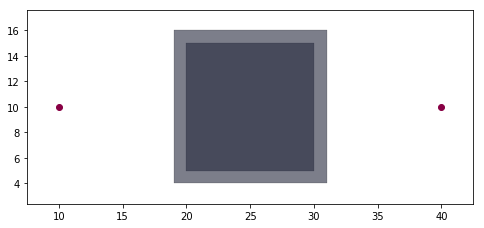

In [9]:
vis_mapa(mapa_1)

### Mapa 2

In [10]:
wp_ori = CartesianPoint(10.0, 10.0)
wp_des = CartesianPoint(40.0, 10.0)

verts1 = [
    (15.0,  8.0), # left, bottom
    (15.0, 20.0), # left, top
    (20.0, 20.0), # right, top
    (20.0,  8.0), # right, bottom
]
verts1 = [CartesianPoint(v[0], v[1]) for v in verts1]

verts2 = [
    (30.0,  0.0), # left, bottom
    (30.0, 12.0), # left, top
    (35.0, 12.0), # right, top
    (35.0,  0.0), # right, bottom
]
verts2 = [CartesianPoint(v[0], v[1]) for v in verts2]

mapa_2 = Mapa(wp_ori, wp_des, [verts1, verts2], inflation_rate=1)

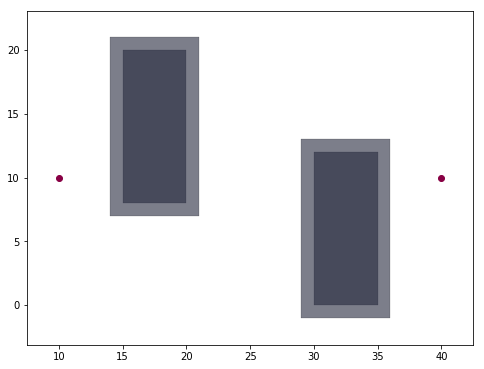

In [11]:
# Visualização desse mapa
vis_mapa(mapa_2)

### Mapa 3

In [12]:
wp_ori = CartesianPoint(10.0, 10.0)
wp_des = CartesianPoint(40.0, 10.0)

verts1 = [
    (15.0, 11.0), # left, bottom
    (15.0, 25.0), # left, top
    (35.0, 23.0), # right, top
    (35.0, 16.0), # right, bottom
]
verts1 = [CartesianPoint(v[0], v[1]) for v in verts1]

verts2 = [
    (15.0,  0.0), # left, bottom
    (15.0,  9.0), # left, top
    (35.0, 12.0), # right, top
    (35.0,  6.0), # right, bottom
]
verts2 = [CartesianPoint(v[0], v[1]) for v in verts2]

mapa_3 = Mapa(wp_ori, wp_des, [verts1, verts2], inflation_rate=0.5)

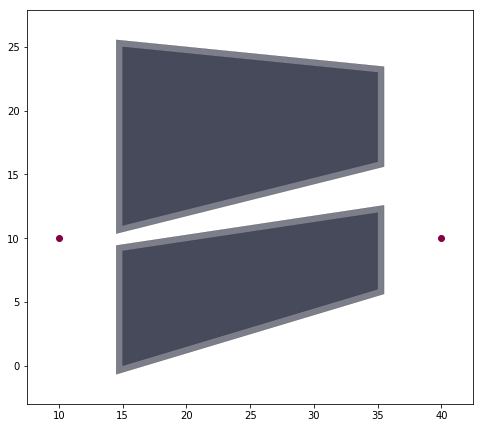

In [13]:
# Visualização desse mapa
vis_mapa(mapa_3)

### Mapa 4

In [14]:
wp_ori = CartesianPoint(40.0, 25.0)
wp_des = CartesianPoint(36.0, -22.0)

verts1 = [
    (19.0,-12.0), # left, bottom
    (15.0,0.0), # left, top
    (87.0,15.0), # right, top
    (90.0,3.0), # right, bottom
]
verts1 = [CartesianPoint(v[0], v[1]) for v in verts1]

# verts1 = [
#     (38.0,-9.0), # left, bottom
#     (38.0,6.0), # left, top
#     (87.0,15.0), # right, top
#     (90.0,3.0), # right, bottom
# ]
# verts1.append(verts1[0])
# verts1 = [CartesianPoint(v[0], v[1]) for v in verts1]

verts2 = [
    (15.0,  0.0), # left, bottom
    (15.0,  9.0), # left, top
    (35.0, 12.0), # right, top
    (35.0,  6.0), # right, bottom
]
verts2 = [CartesianPoint(v[0], v[1]) for v in verts2]

mapa_4 = Mapa(wp_ori, wp_des, [verts1], inflation_rate=0.5)

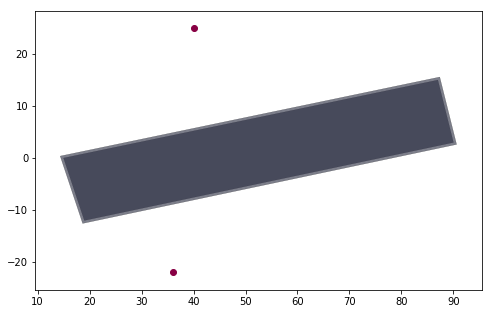

In [15]:
# Visualização desse mapa
vis_mapa(mapa_4)

## Running Example

------------------------------
GeneDecoded(x=40.0, y=25.0, v=0, al=0)
GeneDecoded(x=40.63950277318099, y=25.0, v=1.2790055463619905, al=-3.0167463894204447)
GeneDecoded(x=38.84455080955004, y=24.77473536589137, v=2.3390584149978437, al=-2.338868855520613)
GeneDecoded(x=36.864552785700084, y=22.724911126826697, v=3.360826350681828, al=-1.000688075755468)
GeneDecoded(x=39.08651648327144, y=19.259164876224986, v=4.872889638319691, al=4.492353814752383)
GeneDecoded(x=37.9044711341857, y=13.974068474352615, v=5.958449186475612, al=3.19781502680296)
GeneDecoded(x=30.967969267953944, y=13.583670447362529, v=7.936509433069012, al=-0.8978881484730943)
GeneDecoded(x=36.0795967938959, y=7.170074347319361, v=8.46628921819248, al=-1.6795171088097587)
GeneDecoded(x=35.11841360264068, y=-1.6359060483490568, v=9.25027521806864, al=-1.3672550517597604)
GeneDecoded(x=37.06130750162776, y=-11.04917493106251, v=9.97309262016227, al=-1.6619654493422429)
GeneDecoded(x=36.15053530147522, y=-21.01140103618037

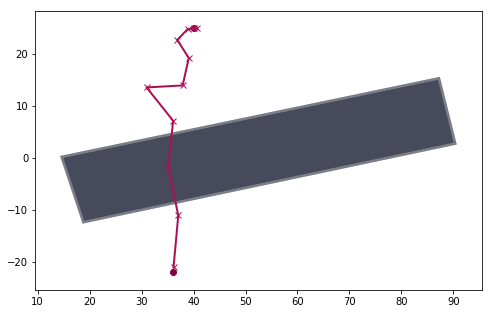

In [41]:
mapa = mapa_4
ag = Genetic(
    Specie=Subject, 
    mapa=mapa,
    px0=mapa.origin.x,
    py0=mapa.origin.y,
    max_exec_time=180,
    NP=10,
    F=0.8,
    CR=0.9,
    C_obs=10000,
)

best = ag.run()

# Print do DNA DECODIFICADO do melhor
print('-'*30)
for dna_decoded in best.dna_decoded:
    print(dna_decoded)
    
# Visualização do Mapa usado, com a rota do melhor de todos
areas = [ area for area in itertools.chain(mapa.areas_n, mapa.areas_n_inf) ]
tipos = [ 'n' for _ in range(len(areas))]
plot_map(
    areas=areas,            # Mapa usado
    labels=tipos,            # Tipo do mapa {'n','p','b'} <- Não afeta o genético, só muda a visualização
    origem=mapa.origin,      # waypoint de origem
    destino=mapa.destination, # waypoint de destino
    waypoints=best.get_route(), # rota do melhor de todos
)

## Running More Maps (SLG)

In [18]:
MAPS_PATH = "./maps/NonRegular/"
EXPERIMENTS_PATH = "./experiments/"
BONUS_PATH = './maps/b_n/bonus_regions.txt'

wp_ori = CartesianPoint(0, 0)
wp_des = CartesianPoint(0, -10)

labels = read_bonus(BONUS_PATH)

In [36]:
par_RC = {
    # Differential Evolution
    'max_exec_time':180,
    'NP':10,
    'F':0.8,
    'CR':0.9,

    # Costs Genetic
    'C_d': 100,            # !
    'C_obs': 1000,         # !
    'C_con': 0,            # !
    'C_cur': 0,            # !
    'C_t': 10,             # !
    'C_dist': 1,
    'v_min': -3.0,         # !
    'v_max': 3.0,          # !
    'e_min': -3,
    'e_max': 3,
    'a_min': -2.0,
    'a_max': 2.0,
}

### Run ONE map

1. Processing file: 27
1.1. Read
2. AG generated: 27
2. Saved: 27


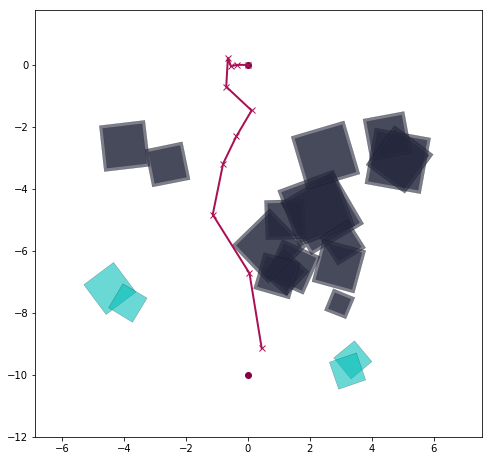

In [27]:
MODE = "DEA"
EXEC = "1"

mapa_name = "27"
ag = run_ags_over_path(MAPS_PATH + mapa_name + ".sgl", show=True)


### Run ALL maps

In [42]:
MODE = "DECCA"
EXEC = "1"

# Run all maps and paralellize the execution
pathlist = PPath(MAPS_PATH).glob("**/*.sgl")

# Iterate over different maps in parallel
p = Pool(processes=50)
p.map(run_ags_over_path, pathlist)

1. Processing file: 31
1. Processing file: 35
1. Processing file: 12
1. Processing file: 37
1. Processing file: 14
1. Processing file: 33
1. Processing file: 00
1. Processing file: 18
1. Processing file: 17
1. Processing file: 39
1. Processing file: 26
1. Processing file: 13
1. Processing file: 07
1. Processing file: 32
1. Processing file: 38
1. Processing file: 21
1. Processing file: 08
1. Processing file: 02
1. Processing file: 15
1. Processing file: 48
1. Processing file: 20
1. Processing file: 01
1. Processing file: 28
1. Processing file: 03
1. Processing file: 40
1. Processing file: 05
1. Processing file: 27
1. Processing file: 10
1. Processing file: 11
1. Processing file: 06
1. Processing file: 04
1. Processing file: 41
1. Processing file: 23
1. Processing file: 22
1. Processing file: 46
1. Processing file: 19
1. Processing file: 42
1. Processing file: 29
1. Processing file: 34
1. Processing file: 44
1. Processing file: 24
1. Processing file: 25
1. Processing file: 30
1. Processi

### MODES

Mode DEA:
```python
{
    # Differential Evolution
    'max_exec_time':10,
    'NP':10,
    'F':0.8,
    'CR':0.9,
    
    # Costs Genetic
    'population_size':10,
    'C_d':1000,
    'C_obs':10000,
    'C_con':500,
    'C_cur':100,
    'C_t':10,
    'C_dist':1,
    'C_z_bonus':-100,
}
```

Mode DEB:
    
```python
{
    'max_exec_time':180, # !
    'NP':10,
    'F':0.8,
    'CR':0.9,
    
    # Costs Genetic
    'population_size':10,
    'C_d':1000,
    'C_obs':10000,
    'C_con':500,
    'C_cur':100,
    'C_t':10,
    'C_dist':1,
    'C_z_bonus':-100,
}
```

Mode DEC
```python
{
    # Differential Evolution
    'max_exec_time':180,
    'NP':10,
    'F':0.8,
    'CR':0.9,

    # Costs Genetic
    'C_d': 100,            # !
    'C_obs': 1000,         # !
    'C_con': 0,            # !
    'C_cur': 0,            # !
    'C_t': 10,             # !
    'C_dist': 1,
    'v_min': -3.0,         # !
    'v_max': 3.0,          # !
    'e_min': -3,
    'e_max': 3,
    'a_min': -2.0,
    'a_max': 2.0,
}
```